# **Bancos** - Análise de Sentimento e Classificação de Temas

### **Resumo dos Passos**

**Extração e Tratamentos de Texto**
- Extração de 5 mil comentários por empresa na Play Store
- Função de tratamento de texto: tradução de emojis, remoção de stopwords, lemmentização e etc

**Análise de Sentimentos e Emoções**
- Verificação do período de comentários para cada empresa
- Aplicação da função com os modelos de sentimento e emoção do Pysentimiento
- Análise por sentimento: visão geral e detalhada de sentimentos por empresa
- Análise por emoção: agrupamento das diversas emoções em grandes emoções gerais e visão por empresa

**Classificação de Temas**
- Criação manual dos temas e aplicação da função de classificação de temas
- Geração do sentimento médio por tema e visão em gráfico de dispersão

In [76]:
#Para realizar paralelismo
import swifter

#Coletados Comentários
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

#Transformar a coluna de versões para fazer filtro melhores
from packaging.version import parse

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Comentários
from pysentimiento import create_analyzer

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-13 09:14:02 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-13 09:14:02 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-13 09:14:05 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-13 09:14:08 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-13 09:14:08 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-13 09:14:08 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-13 09:14:09 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package         |
-------------------------------
|

## Funções 
**tratamento_de_texto**: Funciona para realizar transformação dos emojis para formatos textuais e qualquer coisa relacionadas a possíveis links nos comentaráios. Além da lemmatização dos comentários para um formato mais geral das palavras. 

**classificar_tema**: Após testar alguns modelos de classificação de tópicos, optei por fazer a classificação manual dos temas mais falados com uma lista de termos agrupados em grandes temas gerais que ocorrem com esse setor.

**analisar_sentimento_todos**: O Pysentimiento possui 4 funções de análise de sentimento, optei de realizar a análise sentimento e emoção. Para as emoções, que são gerados diversas emoções em inglês, optei por agrupar em 8 grandes emoções para melhorar a análise.

In [3]:
stopwords_pt = set(stopwords.words("portuguese"))

In [ ]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'\b(banco do brasil|bradesco|caixa|c6|itau|inter|nubank|mercado pago|santander)\b', 'banco', texto)
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zá-úà-üç\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [ ]:
temas_manuais = {
    "App": [r"app", r"aplicativo"],

    "Atend.": [r"atendimento", r"suporte", r"SAC", r"chat", r"central", r"resposta automática", r"humano",
               r"resolveram", r"resolução", r"ninguém resolve", r"reclame aqui", r"demora para resolver",
               r"atendente", r"faq"],

    "Cartões": [r"fatura", r"limite", r"cartão", r"cartões", r"crédito", r"melhor dia de compra", 
                r"anuidade", r"débito", r"compra", r"chip"],

    "Desemp.": [r"lento", r"demora", r"demorando", r"carregamento", r"travando",
                r"bug", r"erro", r"trava", r"não funciona", r"problema", r"falha",
                r"confuso", r"layout", r"interface", r"difícil de usar", r"menu", r"design"],

    "Empréstimo": [r"empréstimo", r"financiamento", r"juros", r"parcelamento", r"crédito pessoal", r"análise de crédito"],

    "Extrato": [r"saldo", r"extrato", r"valor incorreto", r"movimentação", r"não aparece no extrato", r"valor errado",
                r"cobrança indevida", r"taxa", r"valores errados", r"cobrança errada"],

    "Login": [r"login", r"senha", r"erro ao entrar", r"verificação", r"biometria", r"não consigo acessar",
              r"cadastrar", r"atualizar dados", r"endereço", r"telefone", r"comprovante", r"documento",
              r"atualização", r"nova versão", r"sumiu", r"mudaram", r"desatualizado"],

    "Pgtos": [r"boleto", r"vencimento", r"segunda via", r"código de barras", r"pagamento não compensado", r"pagar boleto",
              r"pix", r"transferência", r"transferir", r"transação", r"TED", r"DOC", r"não caiu", r"pendente", r"pgto"],

    "PIX": [r"pix"],

    "Seg.": [r"fraude", r"golpe", r"phishing", r"senha roubada", r"acesso indevido", r"clonaram", r"segurança"]
}

In [3]:
def classificar_tema(texto, temas_dict):
    texto = texto.lower()
    temas_encontrados = []
    for tema, padroes in temas_dict.items():
        for padrao in padroes:
            if re.search(padrao, texto):
                temas_encontrados.append(tema)
                break  # Evita múltiplas adições do mesmo tema
    return temas_encontrados  # Sem categoria 'Outro'

In [5]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emoções resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emoção, substituir output pela categoria agregada
        if tipo == "emotion":
            # Pós-processamento: agregando emoções
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mantém output original
            dados[f"{tipo}_output"] = saida
            # Mantém probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


---
# Extração de Comentários
Aproveitando um script feito em outro [notebook]('https://github.com/PedroReste/data_eng_insights/tree/main/web_scraping_comentarios_apps), será coletado aproximadamente 5 mil comentários de cada aplicativo na Play Store pela consistência dos dados em relação ao iOS. Aproveitando que no caso do Brasil, de forma majoritária, mais usuários de Android do que iOS.

In [6]:
qtd_comentarios = 5000

dados_android = []

apps = {
    "Banco do Brasil": "br.com.bb.android",
    "Bradesco": "com.bradesco",
    "Caixa": "br.com.gabba.Caixa",
    "C6": "com.c6bank.app",
    "Itau": "com.itau",
    "Inter": "br.com.intermedium",
    "Nubank": "com.nu.production",
    "Mercado Pago": "com.mercadopago.wallet",
    "Santander": "com.santander.app"
}

In [7]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [8]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])
comentarios_android.to_csv("comentarios_bancos.csv", index=False)
comentarios_android.shape

(45000, 5)

---
# Análise de Sentimento
Nessa seção será aplicado os tratamentos necessários aos comentários extraídos da Play Store, aplicação dos modelos do Pysentimiento para entender os seus sentimentos e emoções, e finalizando com análises para extrair insights.

### **Insights**

**Informoações Gerais**
- O período dos comentários coletados de cada empresa difere por conta do volume de comentários. A janela geral está entre abril e junho, exceto pelo C6, que o comentário mais antigo é de janeiro.
- No sentimento médio geral, numa escala de -1 e +1, muito negativos e muito positivos, respectivamente. **Nubank**, **Banco do Brasil**, **Inter** e **Mercado Pago** tem um sentimento positivo geral, enqunato **Bradesco**, **Caixa**, **Itaú** e **Santander** são neutros.
- O **C6** é único com sentimento médio negativo entre as 9 empresas. 

**Sentimentos**
- Obeservando as 9 companhias bancárias, dentre os 5 mil comentários de cada, praticamente todas tem mais de 2 mil comentários positivos recentes na Play Store. Exceto pelo **C6**, que possui um pouco mais de 1.5 mil comentários positivos.
- Nos comentários positivos, o top 3 apps com mais comentários positivos são **Nubank**, **Banco do Brasil** e **Inter**.
- Em contra partida, como esses são os apps com mais comentários positivos, acabam sendo também os que tem menos comentários negativos. Além desses, o **Mercado Pago** também possui poucos comentários negativos.
- Tratando de comentários negativos, observandos os que mais possuem atualmente são **C6**, **Itaú** e **Bradesco**.
- Nos sentimentos detalhados, separando os sentimentos positivos e negativos em mais ou menos intensos, alguns comportamentos se mantêm semelhantes e outros têm destaques.
- O **Banco do Brasil** que mais possuí comentários positivos (aprox. 3.6 mil), separando por intensidade, o banco possui principalmente comentários **muito positivos** (aprox. 2.2 mil) e **positivos** (aprox. 1.4 mil) logo em seguida.
- **Inter**, **Nubank**, **Mercado Pago** e **Santander** segue o mesmo comportamento, mas com a diferença menor entre comentários **muito positivos** e **positivos**.
- Nos comentários negativos, **C6**, **Itaú** e **Bradesco** lideravam nos sentimentos gerais. Na visão detalhada, os sentimentos **muito negativos** são os predominantes para essas empresas.
- O ponto interessante é que, para sentimentos negativos, não existem sentimentos negativos pouco intenso, apenas muito intensos.

**Emoções**
- Considerando a média da probabilidade de cada emoção, para todas as empresas, o que predomina são emoções **alegres** e **neutras**.
- Como notado nos sentimentos, acaba tendo a exceção nas emoções para **C6**, **Itaú** e **Bradesco**, que possuem picos de **raiva** nos comentários.


### Informações Gerais

In [9]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|██████████| 45000/45000 [1:19:09<00:00,  9.47it/s]


In [10]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|██████████| 45000/45000 [55:20<00:00, 13.55it/s]  


In [8]:
#data início
print("Data mínima da Banco do Brasil: ", df[df['app']=='Banco do Brasil']['date'].min())
print("Data mínima da Bradesco: ", df[df['app']=='Bradesco']['date'].min())
print("Data mínima da Caixa: ", df[df['app']=='Caixa']['date'].min())
print("Data mínima da C6: ", df[df['app']=='C6']['date'].min())
print("Data mínima da Itau: ", df[df['app']=='Itau']['date'].min())
print("Data mínima da Inter: ", df[df['app']=='Inter']['date'].min())
print("Data mínima da Nubank: ", df[df['app']=='Nubank']['date'].min())
print("Data mínima da Mercado Pago: ", df[df['app']=='Mercado Pago']['date'].min())
print("Data mínima da Santander: ", df[df['app']=='Santander']['date'].min())

Data mínima da Banco do Brasil:  2025-05-26 17:29:58
Data mínima da Bradesco:  2025-04-23 18:50:17
Data mínima da Caixa:  2025-05-29 21:07:58
Data mínima da C6:  2025-01-09 08:17:03
Data mínima da Itau:  2025-05-23 03:34:24
Data mínima da Inter:  2025-05-09 10:36:52
Data mínima da Nubank:  2025-06-08 00:07:19
Data mínima da Mercado Pago:  2025-05-18 19:55:40
Data mínima da Santander:  2025-04-27 08:34:39


In [9]:
#data final
print("Data mínima da Banco do Brasil: ", df[df['app']=='Banco do Brasil']['date'].max())
print("Data mínima da Bradesco: ", df[df['app']=='Bradesco']['date'].max())
print("Data mínima da Caixa: ", df[df['app']=='Caixa']['date'].max())
print("Data mínima da C6: ", df[df['app']=='C6']['date'].max())
print("Data mínima da Itau: ", df[df['app']=='Itau']['date'].max())
print("Data mínima da Inter: ", df[df['app']=='Inter']['date'].max())
print("Data mínima da Nubank: ", df[df['app']=='Nubank']['date'].max())
print("Data mínima da Mercado Pago: ", df[df['app']=='Mercado Pago']['date'].max())
print("Data mínima da Santander: ", df[df['app']=='Santander']['date'].max())

Data mínima da Banco do Brasil:  2025-06-12 09:13:45
Data mínima da Bradesco:  2025-06-12 09:10:31
Data mínima da Caixa:  2025-06-12 09:14:33
Data mínima da C6:  2025-06-12 06:48:16
Data mínima da Itau:  2025-06-12 09:06:42
Data mínima da Inter:  2025-06-12 09:07:20
Data mínima da Nubank:  2025-06-12 09:10:27
Data mínima da Mercado Pago:  2025-06-12 09:13:51
Data mínima da Santander:  2025-06-12 09:03:32


In [11]:
#Sentimento Geral do App
df_explodido = df.explode('app')

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

df_tema = df_explodido.groupby('app').agg(
    volume=('app', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

df_tema['sentimento_medio'] = round(df_tema['sentimento_medio'], 2)
df_tema

,app,volume,sentimento_medio
0,Banco do Brasil,5000,0.45
1,Bradesco,5000,-0.04
2,C6,5000,-0.19
3,Caixa,5000,0.09
4,Inter,5000,0.33
5,Itau,5000,-0.07
6,Mercado Pago,5000,0.31
7,Nubank,5000,0.46
8,Santander,5000,0.18


### Sentimentos

Ao aplicar o modelo de sentimento do Pysentimiento, notei que houve muitas classificações **Neutras** para comentários que poderiam estar como positivos ou negativos. Pelo o que observei, parece que o modelo não lida muito bem com frases muito curtas (5 palavras no máximo).    
Para contornar esse ponto, apliquei duas regras para os gráficos abaixo:
- **Sentimento Simples**: Para os comentários que foram classificados com majoriatariamente como neutros, foi reclassificados os que tiveram a probabilidade abaixo de 70% de serem neutros para o segundo sentimento com maior probabilidade.
- **Sentimento Detalhado**: Para o detalhamento, além da regra dos neutros. Para identificar sentimentos muito fortes, também foi reclassificados sentimentos positivos e negativos que acima de 70% como muito positivos e muito negativos, respectivamente.


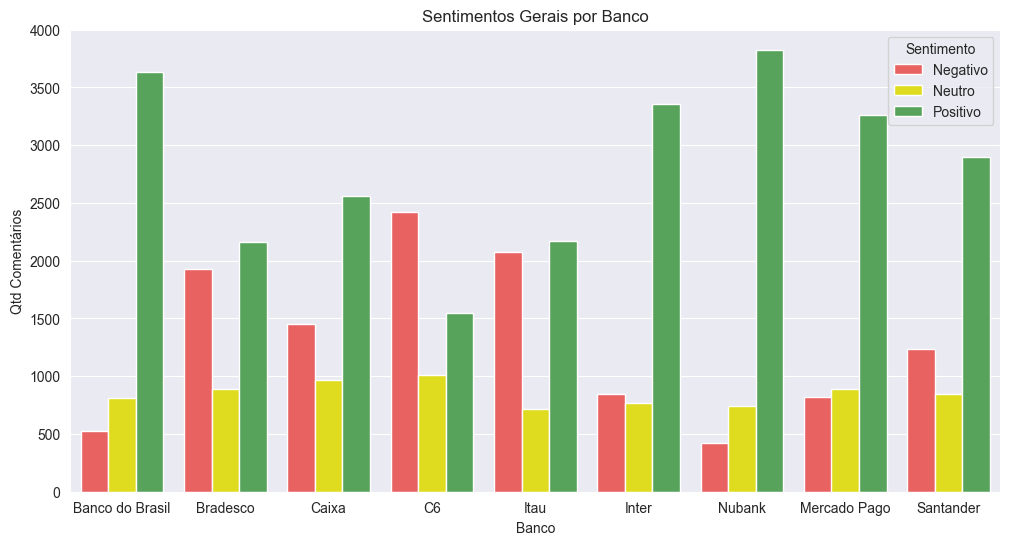

In [48]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Sentimentos Gerais por Banco", loc="center")
plt.xlabel("Banco")
plt.ylabel("Qtd Comentários")
plt.ylim(0, 4000)
plt.legend(title="Sentimento")

plt.show()

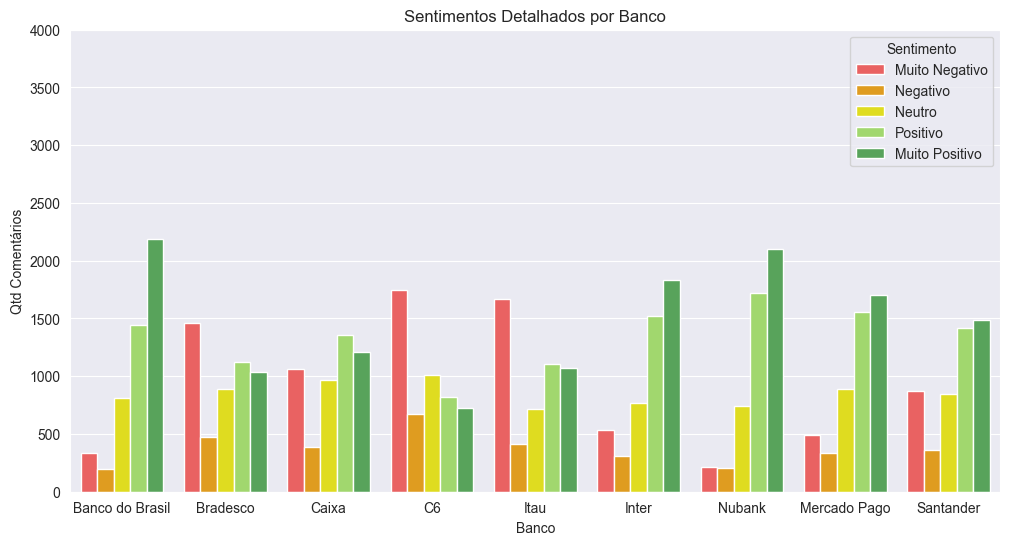

In [49]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Sentimentos Detalhados por Banco", loc="center")
plt.xlabel("Banco")
plt.ylabel("Qtd Comentários")
plt.ylim(0, 4000)
plt.legend(title="Sentimento")

plt.show()

In [ ]:
#Valores dos pontos com base na média de cada sentimento
values_bb = df[df['app'] == 'Banco do Brasil'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_bradesco = df[df['app'] == 'Bradesco'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_caixa = df[df['app'] == 'Caixa'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_c6 = df[df['app'] == 'C6'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_itau = df[df['app'] == 'Itau'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_inter = df[df['app'] == 'Inter'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_nubank = df[df['app'] == 'Nubank'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_mp = df[df['app'] == 'Mercado Pago'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_santander = df[df['app'] == 'Santander'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confiança', 'Confusão', 'Neutro']

In [127]:
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{'type': 'polar'}] *5, [{'type': 'polar'}] *5]
)

# Gráfico 1 - BB
fig.add_trace(go.Scatterpolar(
    r=values_bb,  # Não fechando a linha
    theta=categories,
    fill='toself',
    name='BB',
    line=dict(color='#B8860B'),
    opacity=0.7
), row=1, col=1)

# Gráfico 2 - Bradesco
fig.add_trace(go.Scatterpolar(
    r=values_bradesco,
    theta=categories,
    fill='toself',
    name='Bradesco',
    line=dict(color='#8B0000'),
    opacity=0.7
), row=1, col=2)

# Gráfico 3 - Caixa
fig.add_trace(go.Scatterpolar(
    r=values_caixa,
    theta=categories,
    fill='toself',
    name='Caixa',
    line=dict(color='#00008B'),
    opacity=0.7
), row=1, col=3)

# Gráfico 4 - C6
fig.add_trace(go.Scatterpolar(
    r=values_c6,
    theta=categories,
    fill='toself',
    name='C6',
    line=dict(color='#2F4F4F'),
    opacity=0.7
), row=1, col=4)

# Gráfico 5 - Itau
fig.add_trace(go.Scatterpolar(
    r=values_itau,
    theta=categories,
    fill='toself',
    name='Itau',
    line=dict(color='#D2691E'),
    opacity=0.7
), row=1, col=5)

# Gráfico 6 - Inter
fig.add_trace(go.Scatterpolar(
    r=values_inter,
    theta=categories,
    fill='toself',
    name='Inter',
    line=dict(color='#FF8C00'),
    opacity=0.7
), row=2, col=1)

# Gráfico 7 - Nubank
fig.add_trace(go.Scatterpolar(
    r=values_nubank,
    theta=categories,
    fill='toself',
    name='Nubank',
    line=dict(color='#9932CC'),
    opacity=0.7
), row=2, col=2)

# Gráfico 8 - Mercado Pago
fig.add_trace(go.Scatterpolar(
    r=values_mp,
    theta=categories,
    fill='toself',
    name='Mercado Pago',
    line=dict(color='#1E90FF'),
    opacity=0.7
), row=2, col=3)

# Gráfico 9 - Santander
fig.add_trace(go.Scatterpolar(
    r=values_santander,
    theta=categories,
    fill='toself',
    name='Santander',
    line=dict(color='#B22222'),
    opacity=0.7
), row=2, col=4)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="<b>Distribuição de Emoções por Banco</b>",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False)),
    polar4=dict(radialaxis=dict(visible=False)),
    polar5=dict(radialaxis=dict(visible=False)),
    polar6=dict(radialaxis=dict(visible=False)),
    polar7=dict(radialaxis=dict(visible=False)),
    polar8=dict(radialaxis=dict(visible=False)),
    polar9=dict(radialaxis=dict(visible=False))
)

# Posicionamento dos títulos
fig.add_annotation(dict(font=dict(size=16),
                        x=0.04,
                        y=1.08,
                        showarrow=False,
                        text="<b>Banco do Brasil</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.265,
                        y=1.08,
                        showarrow=False,
                        text="<b>Bradesco</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.08,
                        showarrow=False,
                        text="<b>Caixa</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.715,
                        y=1.08,
                        showarrow=False,
                        text="<b>C6</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.928,
                        y=1.08,
                        showarrow=False,
                        text="<b>Itaú</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.069,
                        y=0.48,
                        showarrow=False,
                        text="<b>Inter</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.27,
                        y=0.48,
                        showarrow=False,
                        text="<b>Nubank</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.498,
                        y=0.48,
                        showarrow=False,
                        text="<b>Mercado Pago</b>",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.737,
                        y=0.48,
                        showarrow=False,
                        text="<b>Santander</b>",
                        xref="paper",
                        yref="paper"))

fig.show()

---
# Classificação de Temas
Nessa seção, o objetivo principal é classificar os principais temas comentados, de maneira manual, e entender o sentimento médio sobre os temas. Aproveitando a aplicação dos modelos de sentimentos e emoções aos comentários, com suas probabilidades.

### **Insights**

**Visão Geral**
- Foram classificados os seguintes temas para ser observados o sentimento médio: App, Desempenho (do App), Login, Atendimento, Segurança, Cartões, Extrato, PIX e Pagamentos.
- Após o detalhamento dos temas, app por app, a visão geral dos app foi o tema mais falado.
- A visão do aplicativo foi bastante distinta, para maioria neutra, para outros poucos negativa ou positiva.
- Quando negativo a visão geral do app, quase sempre relacionado ao desemepenho e o login do app.
- No Nubank e Mercado Pago, o tema sobre Cartões é visto com positivo. Enquanto para os demais bancos e fintechs é um tema negativo.
- Temas como Empréstimo, Extrato,e Segurança foram pouco comentados no geral.

**Banco do Brasil**
- O aplicativo em geral possui uma imagem positiva com base nos comentários da Play Store, sendo o tema com maior volume no Banco do Brasil.
- Atendimento e Segurança, dos poucos comentários que possuem, também são positivos.
- Para os demais classificados, são semelhantes em sentimento e volume, sendo neutros para negativos e entre 50 à 250 comentários feitos.

**Bradesco**
- O Brasdeco distoa das demais empresas com temas sendo todos negativos.
- O app na visão geral é o tema mais falado, com uma visão pouco negativa.
- No entanto, o desempenho é o mais negativo e o segundo mais comentado no período.
- Os demais se no volume e na intensidade do sentimento, estando entre 50 à 300 comentários sobre e negativos no geral.

**Caixa**
- O tema aplicativo segue a tendência como o tema mais comentado, tendo um sentimento neutro para negativo no caso da Caixa.
- Desempenho e Login são os próximos temas mais falados e que possuem uma visão negativa. Pela proximidade, os problemas de desempenho podem estar relacionados com a funcionalidade de login.
- Semelhantes aos outros bancos, os demais temais tem poucos comentários e com sentimento geral entre neutro e negativo.

**C6**
- Parecido com o Bradesco, o C6 possui todos temas classificados como negativos.
- Para empresa, o tema de Cartões acaba sendo o destaque (negativo), como o segundo tema mais falado, logo após o app no geral.
- No geral, no C6 os demais temas possuem bastante comentários no temas escolhidos. Os usuários também comentaram bastante sobre Desempenho, Login, Atendimento e Pgtos.

**Inter**
- Os usuários do Inter têm uma visão geral positiva sobre o app, enquanto os demais temas tendem serem neutros para negativos.
- Os sentimento mais negativos estão focados para o desempenho do app, junto ao login e o atendimento.

**Itaú**
- No Itaú, a visão geral do app é negativa, como retante dos temas mais expressivos, como login, cartões, pix e pgtos.
- Exceto por desempenho do app, que é o segundo tema mais comentado e tem uma visão muito negativa no Itaú.

**Nubank**
- Junto com o Banco do Brasil, a visão geral do app é positiva, sendo as exceções entre todas as empresas até o momento.
- Outro relevantes para os usuários do Nubank é sobre os Cartões, mas esse é neutro. 
- Os demais temas flutuam na intensidade do sentimento, mas possuem pouco volume.

**Mercado Pago**
- O Mercado Pago tem um padrão parecido com o Nubank, com a exceção dos temas menos relevantes, que se agrupam entre um sentimento neutro para negativo.

**Santander**
- O Santander se diferencia dos demais com o Atendimento sendo o tema mais positivo e que possui um volume expressivo de comentários.
- Também segue a tendência do restante dos app sobre a visão geral do aplicativo ser o tema mais comentado e no caso do Santander ter um sentimento neutro sobre o assunto.
- Também segue a tedência de Bradesco, Caixa e Inter do desempenho do app ser o tema mais negativo para a empresa.

## Aplicações gerais
Na célula abaixo é removido os poucos comentários que não foiram possíveis serem trados e ficaram vazios \
Aplicação da classificação manual dos temas, buscando nos comentários as palavras selecionadas e agrupando em temas gerais \
E o cálculo realizado linha, utilizando as probabilidades de sentimento, para verificar um sentimento médio.

In [ ]:
df.dropna(subset="content_proc", inplace=True)

df['tema_manual'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais))

df_explodido = df.explode('tema_manual').dropna(subset=['tema_manual'])

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

Pandas Apply: 100%|██████████| 44779/44779 [00:03<00:00, 14073.49it/s]


## Escala Padrão
Plot dos gráficos de sentimento médio por tema numa escala padrão para todos. Leitura dos eixos: 
- **Eixo Y**: Sentimento médio - Escala entre -1 e +1 para muito negativos e muito positivos, respectivamente.
- **Eixo X**: Volume de comentários por tema - Escala entre -200 e 1.5k de volume, o -200 é apenas para visualizar melhor temas que ficaram mais próximo de 0.

In [50]:
df_grafico = df_explodido[df_explodido["app"] == "Banco do Brasil"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Banco do Brasil</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [51]:
df_grafico = df_explodido[df_explodido["app"] == "Bradesco"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Bradesco</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [52]:
df_grafico = df_explodido[df_explodido["app"] == "Caixa"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Caixa</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [53]:
df_grafico = df_explodido[df_explodido["app"] == "C6"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - C6</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [66]:
df_grafico = df_explodido[df_explodido["app"] == "Inter"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Inter</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [65]:
df_grafico = df_explodido[df_explodido["app"] == "Itau"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Itaú</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [55]:
df_grafico = df_explodido[df_explodido["app"] == "Nubank"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Nubank</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [56]:
df_grafico = df_explodido[df_explodido["app"] == "Mercado Pago"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Mercado Pago</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [57]:
df_grafico = df_explodido[df_explodido["app"] == "Santander"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 1800],
    title="<b>Temas + Falados - Santander</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

## Zoom em alguns apps

In [63]:
df_grafico = df_explodido[df_explodido["app"] == "Banco do Brasil"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-0.5, 0.5],
    range_x=[-200, 500],
    title="<b>Temas + Falados - Banco do Brasil (Zoom nas Escalas)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [64]:
df_grafico = df_explodido[df_explodido["app"] == "Bradesco"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 0],
    range_x=[-200, 500],
    title="<b>Temas + Falados - Bradesco (Zoom nas Escalas)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [60]:
df_grafico = df_explodido[df_explodido["app"] == "Mercado Pago"]

#Agrupamento por tema
df_tema = df_grafico.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gráfico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-0.5, 0],
    range_x=[-200, 500],
    title="<b>Mercado Pago - Temas + Falados (Zoom nas Escalas)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Comentários",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()